In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
# path to up-to-date results of various GNN models
results_files = {
    'default_gcn': '../agg_results/graph_gcn_results.json',
    'default_gin': '../agg_results/graph_gin_results.json',
    'default_gin_small': '../agg_results/graph_gin_small_results.json',
    'default_cheb': '../agg_results/graph_cheb_results.json',
    'default_gatedgcn': '../agg_results/graph_gatedgcn_results.json',
    'default_gcn2': '../agg_results/graph_gcn2_results.json',
}

name_dict = {
    'PyG-TUDataset_DD': 'D&D',
    'PyG-TUDataset_ENZYMES': 'ENZYMES',
    'PyG-TUDataset_PROTEINS': 'PROTEINS',
    'PyG-TUDataset_NCI1': 'NCI1',
    'PyG-TUDataset_IMDB-BINARY': 'IMDB-BINARY',
    'PyG-TUDataset_REDDIT-BINARY': 'REDDIT-BINARY',
    'PyG-TUDataset_REDDIT-MULTI-5K': 'REDDIT-MULTI-5K',
    'PyG-TUDataset_COLLAB': 'COLLAB',
    'PyG-TUDataset_MUTAG': 'MUTAG',
    'PyG-TUDataset_NCI109': 'NCI109',
    'PyG-TUDataset_Synthie': 'Synthie',
    'PyG-TUDataset_SYNTHETICnew': 'SYNTHETICnew',
    'PyG-GNNBenchmarkDataset_MNIST': 'MNIST',
    'PyG-GNNBenchmarkDataset_CIFAR10': 'CIFAR10',
    'PyG-GNNBenchmarkDataset_PATTERN': 'PATTERN',
    'PyG-GNNBenchmarkDataset_CLUSTER': 'CLUSTER',
    'PyG-MalNetTiny_LocalDegreeProfile': 'MalNetTiny',
    'nx_smallworld': 'Small-World',
    'nx_scalefree': 'Scale-Free',
    'OGB_ogbg-molhiv': 'ogbg-molhiv',
    'OGB_ogbg-moltox21': 'ogbg-moltox21',
    }

perturbations = [
    '-',
    'NoNodeFtrs',
    'NodeDeg',
    'LowPass',
    'MidPass',
    'HighPass',
    'NoEdges',
    'FullyConn',
    'Frag-k1',
    'Frag-k2',
    'Frag-k3',
    'FiedlerFrag',
    'RandFtrs',
    'RandRewire'
]

pert_dict = {
    'none': '-',
    'Fragmented-k1': 'Frag-k1',
    'Fragmented-k2': 'Frag-k2',
    'Fragmented-k3': 'Frag-k3',
    'FullyConnected': 'FullyConn',
    'NoEdges': 'NoEdges',
    'NoFeatures': 'NoNodeFtrs',
    'NodeDegree': 'NodeDeg',
    'FiedlerFragmentation': 'FiedlerFrag',
    'BandpassFiltering-lo': 'LowPass',
    'BandpassFiltering-mid': 'MidPass',
    'BandpassFiltering-hi': 'HighPass',
    'RandomNodeFeatures': 'RandFtrs',
    'RandomEdgeRewire': 'RandRewire'
}

ind_cat_dict = {
    'D&D': 'I-2',
    'ENZYMES': 'I-1',
    'PROTEINS': 'I-2',
    'NCI1': 'I-3',
    'IMDB-BINARY': 'I-3',
    'REDDIT-BINARY': 'I-3',
    'REDDIT-MULTI-5K': 'I-3',
    'COLLAB': 'I-3',
    'MUTAG': 'I-2',
    'NCI109': 'I-3',
    'Synthie': 'I-3',
    'SYNTHETICnew': 'I-3',
    'MNIST': 'I-1',
    'CIFAR10': 'I-1',
    'PATTERN': 'I-3',
    'CLUSTER': 'I-3',
    'MalNetTiny': 'I-2',
    'Small-World': 'I-2',
    'Scale-Free': 'I-2',
    'ogbg-molhiv': 'I-2',
    'ogbg-moltox21': 'I-2'
    }
ind_cat_dict = {k: ind_cat_dict[k] for k in sorted(ind_cat_dict)}

In [ ]:
def generate_scores(conf, split_type='test', score_type='auc'):
    results_file = results_files[conf]
    df = pd.read_json(str(results_file))
    df['Dataset'] = df['Dataset'].apply(name_dict.get)
    df['Perturbation'] = df['Perturbation'].apply(pert_dict.get)
    df = df[df['Dataset'].notna()]

    score_name = f'score-{score_type}'
    df = df[df['Split'] == split_type]
    df = df[df[score_name].notna()]
    datasets = sorted(df['Dataset'].unique())

    score_mat = np.zeros((len(datasets), len(perturbations)))
    score_mat[:] = np.nan

    for dataset, group in df.groupby('Dataset'):
        dataset_idx = datasets.index(dataset)

        for perturbation, score in group[['Perturbation', score_name]].values:
            perturbation_idx = perturbations.index(perturbation)
            score_mat[dataset_idx, perturbation_idx] = score * 100

    score_df = pd.DataFrame(score_mat)
    score_df.columns = perturbations
    score_df.index = datasets
    return score_df

In [ ]:
invalid_entries = [('FullyConn', 'D&D'),
                   ('FullyConn', 'MalNetTiny'),
                   ('FullyConn', 'REDDIT-BINARY'),
                   ('FullyConn', 'REDDIT-MULTI-5K'),
                   ('Frag-k3', 'MNIST')]

In [ ]:
df_dict = dict()
for k in results_files.keys():
     scores = generate_scores(k)
     for inv in invalid_entries:
         scores[inv[0]][inv[1]] = np.nan
     df_dict[k] = scores

In [ ]:
scores_dict = dict()
for k in results_files.keys():
    scores_flat = df_dict[k].to_numpy().flatten()
    scores_flat = scores_flat[~np.isnan(scores_flat)]
    scores_dict[k] = np.log2(scores_flat)

In [ ]:
scores_df = pd.DataFrame.from_dict(scores_dict)
scores_df = scores_df.rename(columns={"default_gcn": "GCN",
                                      "default_gin": "GIN",
                                      "default_gin_small": "GIN (L=2)",
                                      "default_cheb": "ChebNet",
                                      "default_gatedgcn": "GatedGCN",
                                      "default_gcn2": "GCN II"},
                             errors="raise")
scores_df

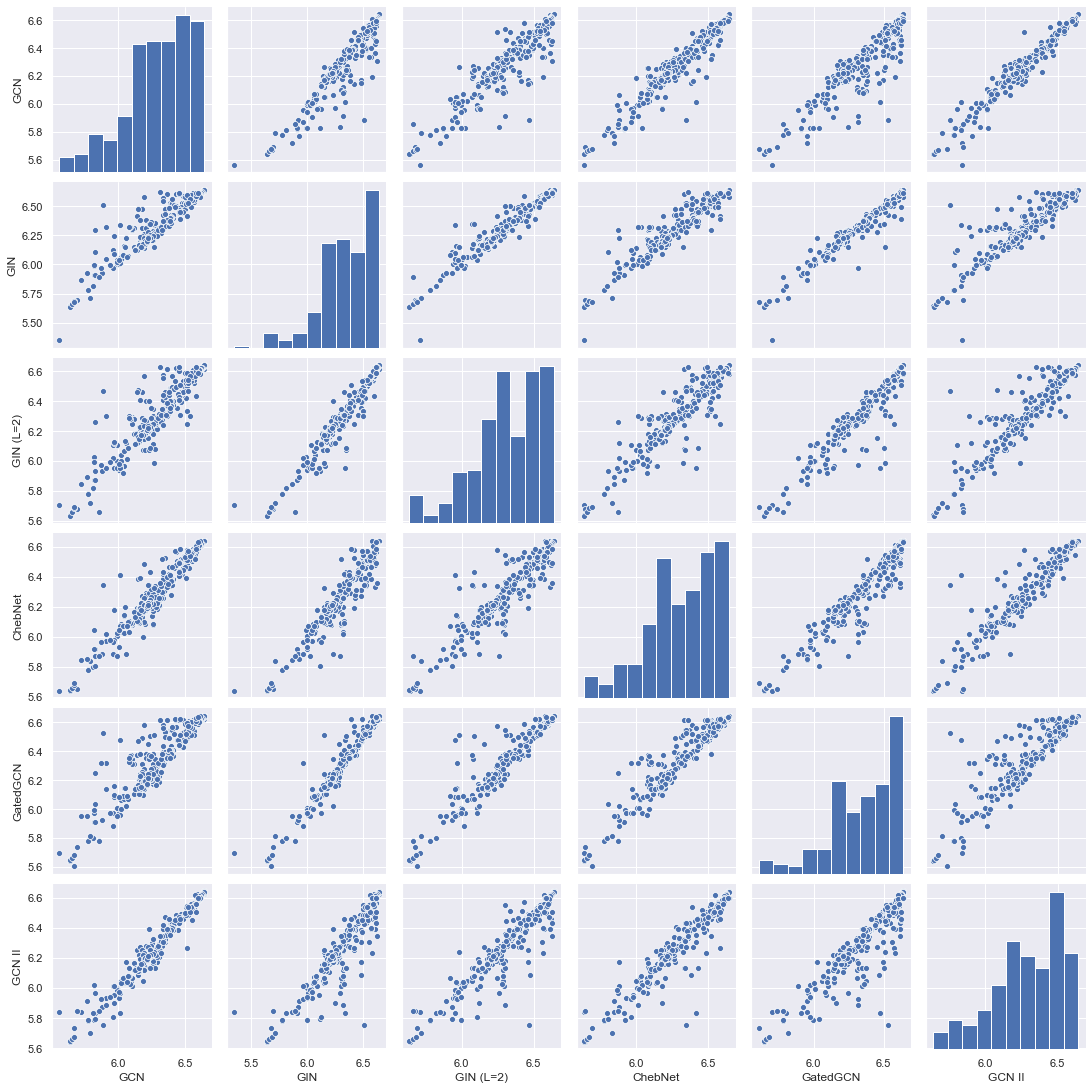

In [15]:
sns.pairplot(scores_df)

[Text(0.5, 0, 'GCN'),
 Text(1.5, 0, 'GIN'),
 Text(2.5, 0, 'GIN (L=2)'),
 Text(3.5, 0, 'ChebNet'),
 Text(4.5, 0, 'GatedGCN'),
 Text(5.5, 0, 'GCN II')]

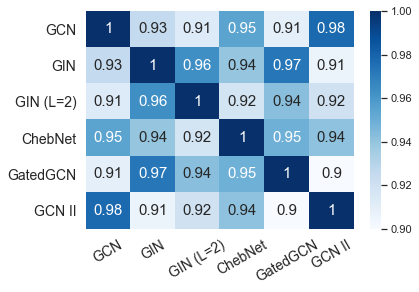

In [16]:
ax = plt.axes()
# ax.set_title('Pearson Correlation', fontsize=15, fontweight='bold')
corr_heatmap = sns.heatmap(scores_df.corr(method='pearson'), annot=True, ax=ax,
                           cmap='Blues', vmin=0.9, vmax=1.0,
                           annot_kws={'fontsize': 15})
corr_heatmap.set_xticklabels(corr_heatmap.get_xmajorticklabels(), fontsize = 14)
corr_heatmap.set_yticklabels(corr_heatmap.get_ymajorticklabels(), fontsize = 14)
ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=30,
            ha='center',
            fontsize=14
        )

In [17]:
fig = corr_heatmap.get_figure()
fig.savefig('GNN-correlations.pdf', bbox_inches='tight', pad_inches=0.02)

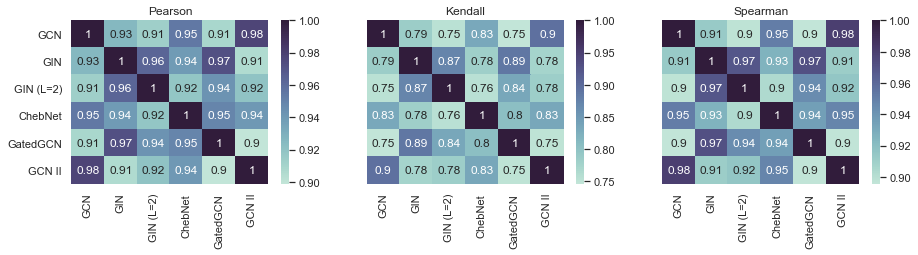

In [18]:
fig, ax = plt.subplots(1,3, figsize=(15, 3), sharey=True)
sns.heatmap(scores_df.corr(method='pearson'), annot=True, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), ax=ax[0])
sns.heatmap(scores_df.corr(method='kendall'), annot=True, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), ax=ax[1])
sns.heatmap(scores_df.corr(method='spearman'), annot=True, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), ax=ax[2])

ax[0].title.set_text('Pearson')
ax[1].title.set_text('Kendall')
ax[2].title.set_text('Spearman')